# NLP workflow

We are going to use an example to go through the general process of NLP. In a lot of documentations, segmentation, cleaning and normalization are combined with name pre-processing. The general idea of pre-processing is reducing the vocabulary's size (which in turn may improve the performance and reduce the resource consuption of downstream tasks) while keeping the most important `flags`. 

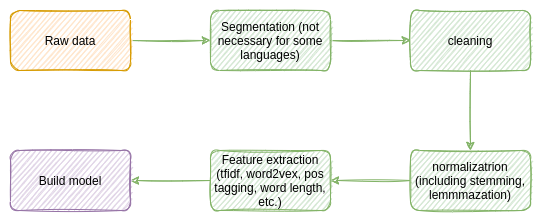

## Segmentation

`input`: _helloworld_

`output`: _hello world_

Segmentation task is not very common in the English / Frech world. In most of the cases, we use segmentation to handle Chinese / Japanese / Korean characters. 

The solutoion of segmentation is pretty standard and usually gives us an accuracy around 95%~97%. From the high level, we can categorize the solution into two classes:
- Rule based (foward max matching, backward max matching)
- Statistic based, e.g. language model, Hidden Markov Model, Conditoinal Random Field

For statistic based segmentation, the core of infering is Viterbi Algorithm (a DP based algorithm). Besides NLP, Viterbi algorithm is also widely used in decoding for communication system. 

Here we will use Chinese as an example to show segmentation works. The library we use is [jieba](https://github.com/jsrpy/Chinese-NLP-Jieba), there are other libraries can serve the same purpose like SnowNLP, LTP, etc.

In [1]:
import jieba
text= "自然语言处理很有趣" # it means natural language processing is interesting
segmentations = jieba.cut(text)

In [2]:
list(segmentations)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.396 seconds.
Prefix dict has been built successfully.


['自然语言', '处理', '很', '有趣']

As we can see in the above example, `jieba` cut the sentence into different word. 

## Cleaning
The purpose of the task is to remvoe useless information (noise) from the text. Depends on which task / model you are dealing with, you will need to choose different cleaning stratgy, i.e. the cleaning is task/model specific. For example, removing stop words is a common techniques in text cleaning. but when using models like `BERT`, it is usually a good idea to keep the stop words.

In general, the common task you can try is removing noise in the text, e.g.
- _stop words_ (e.g. i, me, the)
- `HTML` tags (e.g. `<br>`, `<p>`)
- emoji
- upper case to lower case

### Stop words
Here is an example to show some stop words provided by `NLTK`. In production, you can use Spark NLP to remove stop words.

In [3]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Here is a list of all languages that NLTK provides stop words support
- hungarian
- swedish
- kazakh
- norwegian
- finnish
- arabic
- indonesian
- portuguese
- turkish
- azerbaijani
- slovene
- spanish
- danish
- nepali
- romanian
- greek
- dutch
- tajik
- german
- english
- russian
- french
- italian

### Use Spark NLP to clean your text
In this section we will illustrate how to use spark NLP to clean text

In [5]:
from pyspark.ml.feature import Imputer, OneHotEncoder, RobustScaler, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.sql.dataframe import DataFrame
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from datetime import datetime
from pyspark.ml import Transformer
from pyspark import keyword_only
from pyspark.ml.param.shared import HasOutputCol, Param, Params, HasInputCol
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
import pandas as pd
spark = SparkSession.builder \
    .appName("Spark NLP clean")\
    .master("local[12]")\
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.2.0").getOrCreate()
pd.set_option('display.max_colwidth', None)
pd.set_option('max_colwidth',500)

df = spark.read.format('csv') \
  .option("inferSchema", True) \
  .option("header", True) \
  .option("sep", ',') \
  .load('./bbc-text.csv')

In [6]:
# Display first 10 rows of the content
df.limit(10).toPandas()

,category,text
0,tech,tv future in the hands of viewers with home theatre systems plasma high-definition tvs and digital video recorders moving into the living room the way people watch tv will be radically different in five years time. that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend programmes and other content will be delivered to viewers v...
1,business,worldcom boss left books alone former worldcom boss bernie ebbers who is accused of overseeing an $11bn (£5.8bn) fraud never made accounting decisions a witness has told jurors. david myers made the comments under questioning by defence lawyers who have been arguing that mr ebbers was not responsible for worldcom s problems. the phone company collapsed in 2002 and prosecutors claim that losses were hidden to protect the firm s shares. mr myers has already pleaded guilty to fraud and is...
2,sport,tigers wary of farrell gamble leicester say they will not be rushed into making a bid for andy farrell should the great britain rugby league captain decide to switch codes. we and anybody else involved in the process are still some way away from going to the next stage tigers boss john wells told bbc radio leicester. at the moment there are still a lot of unknowns about andy farrell not least his medical situation. whoever does take him on is going to take a big big gamble. farre...
3,sport,yeading face newcastle in fa cup premiership side newcastle united face a trip to ryman premier league leaders yeading in the fa cup third round. the game - arguably the highlight of the draw - is a potential money-spinner for non-league yeading who beat slough in the second round. conference side exeter city who knocked out doncaster on saturday will travel to old trafford to meet holders manchester united in january. arsenal were drawn at home to stoke and chelsea will play host to scu...
4,entertainment,ocean s twelve raids box office ocean s twelve the crime caper sequel starring george clooney brad pitt and julia roberts has gone straight to number one in the us box office chart. it took $40.8m (£21m) in weekend ticket sales according to studio estimates. the sequel follows the master criminals as they try to pull off three major heists across europe. it knocked last week s number one national treasure into third place. wesley snipes blade: trinity was in second taking $16.1m (£8...
5,politics,howard hits back at mongrel jibe michael howard has said a claim by peter hain that the tory leader is acting like an attack mongrel shows labour is rattled by the opposition. in an upbeat speech to his party s spring conference in brighton he said labour s campaigning tactics proved the tories were hitting home. mr hain made the claim about tory tactics in the anti-terror bill debate. something tells me that someone somewhere out there is just a little bit rattled mr howard said. ...
6,politics,blair prepares to name poll date tony blair is likely to name 5 may as election day when parliament returns from its easter break the bbc s political editor has learned. andrew marr says mr blair will ask the queen on 4 or 5 april to dissolve parliament at the end of that week. mr blair has so far resisted calls for him to name the day but all parties have stepped up campaigning recently. downing street would not be drawn on the claim saying election timing was a matter for the prime mini...
7,sport,henman hopes ended in dubai third seed tim henman slumped to a straight sets defeat in his rain-interrupted dubai open quarter-final against ivan ljubicic. the croatian eighth seed booked his place in the last four with a 7-5 6-4 victory over the british number one. henman had looked on course to level the match after going 2-0 up in the second set but his progress was halted as the rain intervened again. ljubicic hit back after the break to seal a fo

In [7]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentences')

tokenizer = Tokenizer() \
  .setInputCols(["sentences"]) \
  .setOutputCol("token")

# clean tokens 
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)

finisher = Finisher() \
    .setInputCols(["cleanTokens"]) \
    .setOutputCols(["token_features"]) \
    .setOutputAsArray(True) \
    .setCleanAnnotations(False)


pipeline = Pipeline(
    stages=[document_assembler,
            sentenceDetector,
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            finisher]).fit(df)
result = pipeline.transform(df)

cleaned = result.select(['text', 'token_features'])

In [8]:
result.limit(3).toPandas()

,category,text,document,sentences,token,normalized,cleanTokens,token_features
0,tech,tv future in the hands of viewers with home theatre systems plasma high-definition tvs and digital video recorders moving into the living room the way people watch tv will be radically different in five years time. that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend programmes and other content will be delivered to viewers v...,"[(document, 0, 4332, tv future in the hands of viewers with home theatre systems plasma high-definition tvs and digital video recorders moving into the living room the way people watch tv will be radically different in five years time. that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend programmes and other content will be d...","[(document, 0, 217, tv future in the hands of viewers with home theatre systems plasma high-definition tvs and digital video recorders moving into the living room the way people watch tv will be radically different in five years time., {'sentence': '0'}, []), (document, 220, 404, that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes., {'sentence': '1'}, []), ...","[(token, 0, 1, tv, {'sentence': '0'}, []), (token, 3, 8, future, {'sentence': '0'}, []), (token, 10, 11, in, {'sentence': '0'}, []), (token, 13, 15, the, {'sentence': '0'}, []), (token, 17, 21, hands, {'sentence': '0'}, []), (token, 23, 24, of, {'sentence': '0'}, []), (token, 26, 32, viewers, {'sentence': '0'}, []), (token, 34, 37, with, {'sentence': '0'}, []), (token, 39, 42, home, {'sentence': '0'}, []), (token, 44, 50, theatre, {'sentence': '0'}, []), (token, 52, 58, systems, {'sentence':...","[(token, 0, 1, tv, {'sentence': '0'}, []), (token, 3, 8, future, {'sentence': '0'}, []), (token, 10, 11, in, {'sentence': '0'}, []), (token, 13, 15, the, {'sentence': '0'}, []), (token, 17, 21, hands, {'sentence': '0'}, []), (token, 23, 24, of, {'sentence': '0'}, []), (token, 26, 32, viewers, {'sentence': '0'}, []), (token, 34, 37, with, {'sentence': '0'}, []), (token, 39, 42, home, {'sentence': '0'}, []), (token, 44, 50, theatre, {'sentence': '0'}, []), (token, 52, 58, systems, {'sentence':...","[(token, 0, 1, tv, {'sentence': '0'}, []), (token, 3, 8, future, {'sentence': '0'}, []), (token, 17, 21, hands, {'sentence': '0'}, []), (token, 26, 32, viewers, {'sentence': '0'}, []), (token, 39, 42, home, {'sentence': '0'}, []), (token, 44, 50, theatre, {'sentence': '0'}, []), (token, 52, 58, systems, {'sentence': '0'}, []), (token, 61, 66, plasma, {'sentence': '0'}, []), (token, 68, 81, highdefinition, {'sentence': '0'}, []), (token, 84, 86, tvs, {'sentence': '0'}, []), (token, 93, 99, di...","[tv, future, hands, viewers, home, theatre, systems, plasma, highdefinition, tvs, digital, video, recorders, moving, living, room, way, people, watch, tv, radically, different, five, years, time, according, expert, panel, gathered, annual, consumer, electronics, show, las, vegas, discuss, new, technologies, impact, one, favourite, pastimes, us, leading, trend, programmes, content, delivered, viewers, via, home, networks, cable, satellite, telecoms, companies, broadband, service, providers, f..."
1,business,worldcom boss left books alone former worldcom boss bernie ebbers who is accused of overseeing an $11bn (£5.8bn) fraud never made accounting decisions a witness has told jurors. david myers made the comments under questioning by defence lawyers who have been arguing that mr ebbers was not responsible for worldcom s problems. the phone company collapsed in 2002 and prosecutors claim that losses were hidden

## Normalization
Normalization can reduce the size of dictionary, which can help improve the performance of a lot of models. _Notes:_ for models like `BERT`, `GPT` or `XLNET`, normalization is not mandatory. Also for tasks like NER, POS Tagging, we cannot use normalization.
From the high level, there are two tasks in normalization:
- stemming
- lemmalization

### Stemming
`input`: went / go / going

`output`: go

A lot of stemming process is based on `Poter Stemmer` (a rule based word transformer). Since it is rule based, it also means the output may not be an `English` word. For example, the stemmer will convert `fly / flies` to `fli`. 

### Lemmatization
Since the output of stemming may not be an English word, the goal of lemmatization is to convert the word to a true English word.

### Use Spark NLP to do text nornalization

In [9]:
document_assembler = DocumentAssembler() \
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer()\
  .setInputCols(["document"]) \
  .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)

stemmer = Stemmer() \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("stem")


lemmatizer = Lemmatizer() \
    .setInputCols(["stem"]) \
    .setOutputCol("lemma") \
    .setDictionary("./AntBNC_lemmas_ver_001.txt", value_delimiter ="\t", key_delimiter = "->")

finisher = Finisher() \
    .setInputCols(["lemma"]) \
    .setOutputCols(["token_features"]) \
    .setOutputAsArray(True) \
    .setCleanAnnotations(False)

pipeline = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            normalizer,
            stopwords_cleaner,
            stemmer,
            lemmatizer,
            finisher]).fit(df)
result = pipeline.transform(df)

result.limit(3).toPandas()

,category,text,document,token,normalized,cleanTokens,stem,lemma,token_features
0,tech,tv future in the hands of viewers with home theatre systems plasma high-definition tvs and digital video recorders moving into the living room the way people watch tv will be radically different in five years time. that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend programmes and other content will be delivered to viewers v...,"[(document, 0, 4332, tv future in the hands of viewers with home theatre systems plasma high-definition tvs and digital video recorders moving into the living room the way people watch tv will be radically different in five years time. that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend programmes and other content will be d...","[(token, 0, 1, tv, {'sentence': '0'}, []), (token, 3, 8, future, {'sentence': '0'}, []), (token, 10, 11, in, {'sentence': '0'}, []), (token, 13, 15, the, {'sentence': '0'}, []), (token, 17, 21, hands, {'sentence': '0'}, []), (token, 23, 24, of, {'sentence': '0'}, []), (token, 26, 32, viewers, {'sentence': '0'}, []), (token, 34, 37, with, {'sentence': '0'}, []), (token, 39, 42, home, {'sentence': '0'}, []), (token, 44, 50, theatre, {'sentence': '0'}, []), (token, 52, 58, systems, {'sentence':...","[(token, 0, 1, tv, {'sentence': '0'}, []), (token, 3, 8, future, {'sentence': '0'}, []), (token, 10, 11, in, {'sentence': '0'}, []), (token, 13, 15, the, {'sentence': '0'}, []), (token, 17, 21, hands, {'sentence': '0'}, []), (token, 23, 24, of, {'sentence': '0'}, []), (token, 26, 32, viewers, {'sentence': '0'}, []), (token, 34, 37, with, {'sentence': '0'}, []), (token, 39, 42, home, {'sentence': '0'}, []), (token, 44, 50, theatre, {'sentence': '0'}, []), (token, 52, 58, systems, {'sentence':...","[(token, 0, 1, tv, {'sentence': '0'}, []), (token, 3, 8, future, {'sentence': '0'}, []), (token, 17, 21, hands, {'sentence': '0'}, []), (token, 26, 32, viewers, {'sentence': '0'}, []), (token, 39, 42, home, {'sentence': '0'}, []), (token, 44, 50, theatre, {'sentence': '0'}, []), (token, 52, 58, systems, {'sentence': '0'}, []), (token, 61, 66, plasma, {'sentence': '0'}, []), (token, 68, 81, highdefinition, {'sentence': '0'}, []), (token, 84, 86, tvs, {'sentence': '0'}, []), (token, 93, 99, di...","[(token, 0, 1, tv, {'sentence': '0'}, []), (token, 3, 8, futur, {'sentence': '0'}, []), (token, 17, 21, hand, {'sentence': '0'}, []), (token, 26, 32, viewer, {'sentence': '0'}, []), (token, 39, 42, home, {'sentence': '0'}, []), (token, 44, 50, theatr, {'sentence': '0'}, []), (token, 52, 58, system, {'sentence': '0'}, []), (token, 61, 66, plasma, {'sentence': '0'}, []), (token, 68, 81, highdefinit, {'sentence': '0'}, []), (token, 84, 86, tv, {'sentence': '0'}, []), (token, 93, 99, digit, {'se...","[(token, 0, 1, tv, {'sentence': '0'}, []), (token, 3, 8, futur, {'sentence': '0'}, []), (token, 17, 21, hand, {'sentence': '0'}, []), (token, 26, 32, viewer, {'sentence': '0'}, []), (token, 39, 42, home, {'sentence': '0'}, []), (token, 44, 50, theatr, {'sentence': '0'}, []), (token, 52, 58, system, {'sentence': '0'}, []), (token, 61, 66, plasma, {'sentence': '0'}, []), (token, 68, 81, highdefinit, {'sentence': '0'}, []), (token, 84, 86, tv, {'sentence': '0'}, []), (token, 93, 99, digit, {'se...","[tv, futur, hand, viewer, home, theatr, system, plasma, highdefinit, tv, digit, video, record, move, live, room, wai, peopl, watch, tv, radic, differ, five, year, time, accord, expert, panel, gather, annual, consum, electron, show, la, vega, discuss, new, technologi, impact, on, favourit, pastim, u, lead, trend, programm, content, deliv, viewer, via, home, network, cabl, satellit, telecom, compani, broadband, 

In [10]:
from pyspark.sql import functions as F
result_df = result.select(F.explode(F.arrays_zip('cleanTokens.result', 'stem.result',  'lemma.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("stem"),
        F.expr("cols['2']").alias("lemma")).where(F.col("stem")!=F.col("lemma")).where(F.col("stem")!=F.col("token")).limit(20).toPandas()

result_df
# result_df.head(50)

,token,stem,lemma
0,used,us,we
1,increasing,increas,increa
2,increased,increas,increa
3,else,els,el
4,use,us,we
5,used,us,we
6,sense,sens,sen
7,increase,increas,increa
8,course,cours,cour
9,cursing,curs,cur


_note:_ after nornalization, we can see the meaning for some word has been totally changed, which will introduce more noise to the downstream tasks instead of de-noise. It's always a trade off to choose the correct text processing piepline.

In general, pre-processing is highly depends on the data itself, downstream model and task. You need to have a good understand of your data, task and downstream model before choosing the `correct` pre-process pipeline. 